# Introduction to pySpark 2.0.1

### Sources

http://spark.apache.org/

https://databricks.com/spark/about

https://en.wikipedia.org/wiki/Apache_Hadoop

https://github.com/jdorfman/awesome-json-datasets

https://api.hearthstonejson.com/v1/latest/enUS/cards.json

### Get Data and a Quick Introduction to Jupyter Notebooks

In [1]:
from IPython.display import IFrame
import requests
import json

In [2]:
# Aggregations


In [3]:
r = requests.get('https://api.hearthstonejson.com/v1/latest/enUS/cards.json')

In [4]:
with open('data.json', 'w') as f:
    f.write(r.text)

### Intro To Spark

#### Timeline
- 2004 [Mapreduce](http://research.google.com/archive/mapreduce.html): A processing framework for big data sets 
- 2006 [Hadoop](https://hadoop.apache.org/): Distributed file system
- 2009 [Spark](https://en.wikipedia.org/wiki/Matei_Zaharia): Processing framework idea created
- 2012 Hadoop 1.0 released
- 2013 [Hive](https://hive.apache.org/): SQL-like queries on Hadoop
- 2014 Spark 1.0 released
- 2015 Hive 1.0 released
- 2016 Spark 2.0 released

#### Description of Spark

[Open source](https://github.com/apache/spark) processing engine. Built for speed and ease of use. Currently has over 1,000 contributors and adopted by large companies like Yahoo and Netflix. Applications can be written in Java, Scala, Python and R with similar verbage. General stacks of SQL/Dataframe, Streaming, MLib, and GraphX. Runs in many environments Hadoop, Mesos or standalone.


#### Spark version comparison

Spark 1.6 was released in January, 2016. Spark 2.0 was released in July, 2016 (we are using 2.0.1 released in October, 2016). Major differences (if you ever need to go back to 1.6)
- Dataframe and Dataset have been unified
- SparkSession replaces the need for separate contexts
- Improved SQL functionality and performance
- Experimental 'Structured Streaming'



### How does Spark work?

#### [Cluster mode](http://spark.apache.org/docs/latest/cluster-overview.html)

![title](http://spark.apache.org/docs/latest/img/cluster-overview.png)

- App: User program built on Spark
- Driver: Process running the main() function and creating the SparkContext
- Worker: Any node that can run the app code
- Executor: Process launched for an application on a worker - keeps data in memory
- Task: Unit of work sent to an executor
- Job: Parallel computation consisting of multiple tasks
- Stage: Part of a task


### Spark Session

#### What is a SparkSession?

A Spark session provides a single point of entry to interact with Sparks underlying functionality. It allows programming Spark with Dataset APIs. Once a spark session is created, users have access to the spark and sql contexts.


In [5]:
# Build a Spark Session for examples
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

    
spark.version

'2.0.1'

### Small Spark Test

In [6]:
# simple task to test that Spark is running
rdd = spark.sparkContext.parallelize(range(1000))
rdd

PythonRDD[1] at RDD at PythonRDD.scala:48

In [7]:
rdd.takeSample(False, 5)

[652, 388, 59, 556, 594]

If you see five random numbers above, everything is working!

### What is an RDD?

An [RDD](http://spark.apache.org/docs/latest/programming-guide.html#resilient-distributed-datasets-rdds) is a Resilient Distributed Dataset. A fault tolerant collection of elements which can be operated on in parallel. Let's use RDDs for a bit.

In [8]:
rdd

PythonRDD[1] at RDD at PythonRDD.scala:48

In [9]:
rdd

PythonRDD[1] at RDD at PythonRDD.scala:48

In [10]:
IFrame("http://spark.apache.org/docs/latest/programming-guide.html#transformations", 1000, 300)

In [11]:
rdd.take(5)

[0, 1, 2, 3, 4]

In [12]:
rdd.count()

1000

In [13]:
rdd.reduce(lambda a, b: a + b)

499500

In [14]:
rdd.map(lambda x: 2*x).reduce(lambda a, b: a + b)

999000

In [15]:
rdd.map(lambda x: 2*x).filter(lambda x: x < 10).reduce(lambda a, b: a + b)

20

In [16]:
def times_two(x):
    return 2 * x

def less_than_ten(x):
    return x < 10

def add_together(x, y):
    return x + y

rdd.map(times_two).filter(less_than_ten).reduce(add_together)

20

RDD's are the fundamental building block of data in Spark.

Now for another test to show more of the functionality of Spark Parallelize.

In [17]:
partitions = 5 # How many times to break up the computation

#Spark pi approximation example
from random import random
from operator import add

n = 100000 * partitions # Number of times to run the computation
range_data = range(1, n + 1) # Data to be parallelized

def f(_):
    x = random() * 2 - 1
    y = random() * 2 - 1
    return 1 if x ** 2 + y ** 2 < 1 else 0

count = spark.sparkContext.parallelize(range_data, partitions).map(f).reduce(add)
print("Pi is roughly %f" % (4.0 * count / n))


Pi is roughly 3.136400


### Spark UI

Lets run some code through the command line and take a look at the Spark UI

We will open the Spark UI through the link http://localhost:4040

Nothing will be there yet. Go back to our Jupyter Home and open a new terminal. In the terminal window, paste and run the following command.


```
/spark/bin/spark-submit /spark/examples/src/main/python/pi.py 2
```


### Warning
Warning about distributed computations (and thus RDDs). Don't do this:

In [18]:
counter = 0

# Wrong: Don't do this!!
def increment_counter(x):
    global counter
    counter += x

rdd.foreach(increment_counter)

print("Counter value: ", counter)

Counter value:  0


### [Closures](http://spark.apache.org/docs/latest/programming-guide.html#understanding-closures-a-nameclosureslinka)
One of the hardest things about running Spark on a cluster is the scope and lifecycle of variables. The behavior of the above loop is undefined. To execute jobs, Spark breaks up the processing of RDD operations into tasks. Prior to execution, Spark computes a tasks **closure**. A closure is the variables and methods which must be visible for the exectutor to perform its computations on the RDD. the counter which is incremented in the closure is likely to not be the counter in the driver.

In short, don't mutate global state inside a closure.

### DataFrames/DataSets

In [19]:
from pyspark.sql import Row

Student = Row("first", "last", "graduation_year")

Student

<Row(first, last, graduation_year)>

In [20]:
Student("J", "Smith", 2017)

Row(first='J', last='Smith', graduation_year=2017)

In [21]:
from pyspark.sql import Row

row = Row("value") # value is our column name

rdd = spark.sparkContext.parallelize(range(1000))

df = rdd.map(row).toDF()
df

DataFrame[value: bigint]

In [22]:
df.take(5)

[Row(value=0), Row(value=1), Row(value=2), Row(value=3), Row(value=4)]

In [23]:
df.count()

1000

In [24]:
df # There is no longer a map or reduce option

DataFrame[value: bigint]

In [25]:
from pyspark.sql.functions import *

In [26]:
df.agg(sum(df.value))

DataFrame[sum(value): bigint]

In [27]:
df.agg(sum(df.value)).collect()

[Row(sum(value)=499500)]

### Reading Json Data With Spark

In [28]:
df = spark.read.json('data.json')

df

DataFrame[artist: string, attack: bigint, collectible: boolean, cost: bigint, durability: bigint, dust: array<bigint>, entourage: array<string>, faction: string, flavor: string, health: bigint, howToEarn: string, howToEarnGolden: string, id: string, mechanics: array<string>, name: string, overload: bigint, playRequirements: struct<REQ_DAMAGED_TARGET:bigint,REQ_ENEMY_TARGET:bigint,REQ_ENEMY_WEAPON_EQUIPPED:bigint,REQ_ENTIRE_ENTOURAGE_NOT_IN_PLAY:bigint,REQ_FRIENDLY_MINION_DIED_THIS_GAME:bigint,REQ_FRIENDLY_TARGET:bigint,REQ_FROZEN_TARGET:bigint,REQ_HERO_TARGET:bigint,REQ_LEGENDARY_TARGET:bigint,REQ_MINIMUM_ENEMY_MINIONS:bigint,REQ_MINIMUM_TOTAL_MINIONS:bigint,REQ_MINION_OR_ENEMY_HERO:bigint,REQ_MINION_SLOT_OR_MANA_CRYSTAL_SLOT:bigint,REQ_MINION_TARGET:bigint,REQ_MUST_TARGET_TAUNTER:bigint,REQ_NONSELF_TARGET:bigint,REQ_NUM_MINION_SLOTS:bigint,REQ_SECRET_CAP_FOR_NON_SECRET:bigint,REQ_STEADY_SHOT:bigint,REQ_STEALTHED_TARGET:bigint,REQ_TARGET_FOR_COMBO:bigint,REQ_TARGET_IF_AVAILABLE:bigint,

In [29]:
# Displays 5 rows of the the contents of data.json
df.show(5)

+----------------+------+-----------+----+----------+----------------+--------------------+-------+--------------------+------+--------------------+--------------------+--------------------+---------------+--------------------+--------+--------------------+-----------+-----+---------+-----+-----------+------------------+--------------------+-----------+
|          artist|attack|collectible|cost|durability|            dust|           entourage|faction|              flavor|health|           howToEarn|     howToEarnGolden|                  id|      mechanics|                name|overload|    playRequirements|playerClass| race|   rarity|  set|spellDamage|targetingArrowText|                text|       type|
+----------------+------+-----------+----+----------+----------------+--------------------+-------+--------------------+------+--------------------+--------------------+--------------------+---------------+--------------------+--------+--------------------+-----------+-----+---------+---

In [30]:
df.columns

['artist',
 'attack',
 'collectible',
 'cost',
 'durability',
 'dust',
 'entourage',
 'faction',
 'flavor',
 'health',
 'howToEarn',
 'howToEarnGolden',
 'id',
 'mechanics',
 'name',
 'overload',
 'playRequirements',
 'playerClass',
 'race',
 'rarity',
 'set',
 'spellDamage',
 'targetingArrowText',
 'text',
 'type']

In [31]:
# Sum columns
df_sum = df.groupBy(['playerClass']).sum()

In [32]:
# Lazy evaluation, note the non-numeric columns were dropped
df_sum.show()

+-----------+-----------+---------+---------------+-----------+-------------+----------------+
|playerClass|sum(attack)|sum(cost)|sum(durability)|sum(health)|sum(overload)|sum(spellDamage)|
+-----------+-----------+---------+---------------+-----------+-------------+----------------+
|     HUNTER|        153|      258|             10|        257|         null|            null|
|       null|       null|        2|           null|       null|         null|            null|
|     SHAMAN|        141|      245|             24|        228|           26|               2|
|    PALADIN|        117|      250|             21|        174|         null|            null|
|       MAGE|        123|      287|           null|        472|         null|               5|
|     PRIEST|        112|      246|           null|        196|         null|               1|
|    WARLOCK|        176|      310|              8|        363|         null|            null|
|    NEUTRAL|       3198|     4140|             90

In [33]:
# Generate Averages of Numeric columns
df_avg = df.groupBy(
    [
        'playerClass',
    ]
).avg()

In [34]:
df_avg.sort(
    'avg(attack)'
).select(
    [
        'playerClass', 
        'avg(attack)',
    ]
).show()

+-----------+------------------+
|playerClass|       avg(attack)|
+-----------+------------------+
|       null|              null|
|DEATHKNIGHT|              null|
|     SHAMAN|              2.82|
|     HUNTER|2.8867924528301887|
|    PALADIN|               3.0|
|    WARRIOR|              3.12|
|      ROGUE|3.2291666666666665|
|     PRIEST|3.2941176470588234|
|    WARLOCK|3.3846153846153846|
|       MAGE|3.5142857142857142|
|      DRUID|3.7058823529411766|
|    NEUTRAL|3.7890995260663507|
|      DREAM|               5.0|
+-----------+------------------+



### Plotting the results

In [35]:
# Import a common plotting library
import seaborn as sns
%matplotlib inline


In [36]:
# Most plotting libraries require a conversion from spark dataframes to plot. Pandas is a good target
df_plot = df_avg.toPandas()

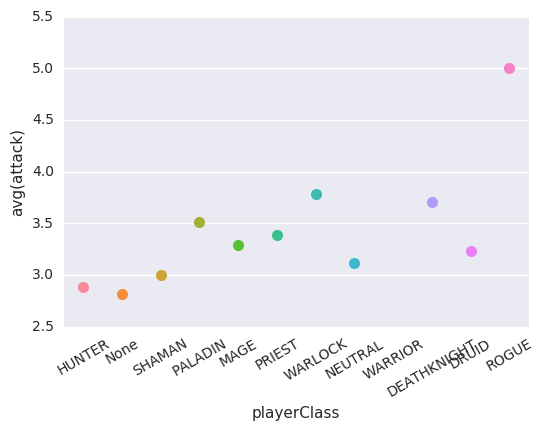

In [37]:
# Show the results of a linear regression within each dataset
p = sns.swarmplot(
    x='playerClass', 
    y="avg(attack)", 
    data=df_plot,
    size=8,
).set_xticklabels( # Makes the axix labels look a bit better
    df_plot['playerClass'], 
    rotation=30
)


In [38]:
df_plot = df.sort(
    'playerClass'
).toPandas()

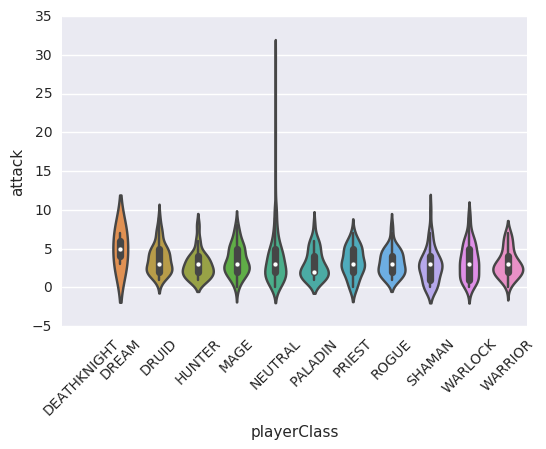

In [39]:
ax = sns.violinplot(
    x='playerClass', 
    y="attack", 
    data=df_plot
)

# Makes the axis readable
for item in ax.get_xticklabels():
    item.set_rotation(45)

ax

### MLLib Library

Spark has a nicely sized machine learning library available in [pyspark.mllib](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html)

Let's run the Random Forest model from the examples on the page

In [40]:
IFrame("http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html", 950, 300)

In [41]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import RandomForest

data = [
    LabeledPoint(0.0, [0.0]),
    LabeledPoint(0.0, [1.0]),
    LabeledPoint(1.0, [2.0]),
    LabeledPoint(1.0, [3.0])
]
# Note the example has sc in place of spark.sparkContext
model = RandomForest.trainClassifier(
    data=spark.sparkContext.parallelize(data), 
    numClasses=2, 
    categoricalFeaturesInfo={}, 
    numTrees=3, 
    seed=42
)
model.numTrees()

3

In [42]:
model.totalNumNodes()

7

In [43]:
model

TreeEnsembleModel classifier with 3 trees

In [44]:
print(model.toDebugString())

TreeEnsembleModel classifier with 3 trees

  Tree 0:
    Predict: 1.0
  Tree 1:
    If (feature 0 <= 1.0)
     Predict: 0.0
    Else (feature 0 > 1.0)
     Predict: 1.0
  Tree 2:
    If (feature 0 <= 1.0)
     Predict: 0.0
    Else (feature 0 > 1.0)
     Predict: 1.0



In [45]:
model.predict([2.0])

1.0

In [46]:
model.predict([0.0])

0.0

In [47]:
test_rdd = spark.sparkContext.parallelize([[3.0], [1.0]])
model.predict(test_rdd).collect()

[1.0, 0.0]

### Predict Attack By Cost

In [48]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+--------+-----------+
|summary|            attack|              cost|        durability|            health|overload|spellDamage|
+-------+------------------+------------------+------------------+------------------+--------+-----------+
|  count|              1258|              2168|                65|              1368|      28|         23|
|   mean|3.6009538950715423|3.0452029520295203|3.1076923076923078|   8.3296783625731|     1.0|        1.0|
| stddev|3.3128662245221894| 2.749130005497297|1.7059003938818214|13.825866449207046|     0.0|        0.0|
|    min|                 0|                 0|                 1|                 0|       1|          1|
|    max|                30|                50|                 8|               200|       1|          1|
+-------+------------------+------------------+------------------+------------------+--------+-----------+



In [49]:
df.columns

['artist',
 'attack',
 'collectible',
 'cost',
 'durability',
 'dust',
 'entourage',
 'faction',
 'flavor',
 'health',
 'howToEarn',
 'howToEarnGolden',
 'id',
 'mechanics',
 'name',
 'overload',
 'playRequirements',
 'playerClass',
 'race',
 'rarity',
 'set',
 'spellDamage',
 'targetingArrowText',
 'text',
 'type']

In [50]:
train_rdd = df.select('attack', 'playerClass', 'cost', 'rarity').where(df.attack.isNotNull()).rdd

In [51]:
train_rdd.take(5)

[Row(attack=5, playerClass='NEUTRAL', cost=4, rarity='LEGENDARY'),
 Row(attack=7, playerClass='WARLOCK', cost=9, rarity='LEGENDARY'),
 Row(attack=1, playerClass='NEUTRAL', cost=3, rarity='COMMON'),
 Row(attack=5, playerClass='NEUTRAL', cost=5, rarity='LEGENDARY'),
 Row(attack=3, playerClass='NEUTRAL', cost=4, rarity='LEGENDARY')]

In [52]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer


In [53]:
playerIndexer = StringIndexer(inputCol="playerClass", outputCol="playerClassIndex")
playerModel = playerIndexer.fit(df)
train_df = playerModel.transform(df) # We get a NullPointerException here

Py4JJavaError: An error occurred while calling o266.transform.
: java.lang.NullPointerException
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$hash(Metadata.scala:215)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$2.apply(Metadata.scala:203)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$2.apply(Metadata.scala:203)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:35)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.AbstractTraversable.map(Traversable.scala:104)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$hash(Metadata.scala:203)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$1.apply(Metadata.scala:200)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$1.apply(Metadata.scala:200)
	at scala.collection.MapLike$MappedValues$$anonfun$foreach$3.apply(MapLike.scala:245)
	at scala.collection.MapLike$MappedValues$$anonfun$foreach$3.apply(MapLike.scala:245)
	at scala.collection.TraversableLike$WithFilter$$anonfun$foreach$1.apply(TraversableLike.scala:733)
	at scala.collection.immutable.Map$Map3.foreach(Map.scala:161)
	at scala.collection.TraversableLike$WithFilter.foreach(TraversableLike.scala:732)
	at scala.collection.MapLike$MappedValues.foreach(MapLike.scala:245)
	at scala.util.hashing.MurmurHash3.unorderedHash(MurmurHash3.scala:91)
	at scala.util.hashing.MurmurHash3$.mapHash(MurmurHash3.scala:222)
	at scala.collection.GenMapLike$class.hashCode(GenMapLike.scala:35)
	at scala.collection.AbstractMap.hashCode(Map.scala:59)
	at scala.runtime.ScalaRunTime$.hash(ScalaRunTime.scala:206)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$hash(Metadata.scala:200)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$1.apply(Metadata.scala:200)
	at org.apache.spark.sql.types.Metadata$$anonfun$org$apache$spark$sql$types$Metadata$$hash$1.apply(Metadata.scala:200)
	at scala.collection.MapLike$MappedValues$$anonfun$foreach$3.apply(MapLike.scala:245)
	at scala.collection.MapLike$MappedValues$$anonfun$foreach$3.apply(MapLike.scala:245)
	at scala.collection.TraversableLike$WithFilter$$anonfun$foreach$1.apply(TraversableLike.scala:733)
	at scala.collection.immutable.Map$Map1.foreach(Map.scala:116)
	at scala.collection.TraversableLike$WithFilter.foreach(TraversableLike.scala:732)
	at scala.collection.MapLike$MappedValues.foreach(MapLike.scala:245)
	at scala.util.hashing.MurmurHash3.unorderedHash(MurmurHash3.scala:91)
	at scala.util.hashing.MurmurHash3$.mapHash(MurmurHash3.scala:222)
	at scala.collection.GenMapLike$class.hashCode(GenMapLike.scala:35)
	at scala.collection.AbstractMap.hashCode(Map.scala:59)
	at scala.runtime.ScalaRunTime$.hash(ScalaRunTime.scala:206)
	at org.apache.spark.sql.types.Metadata$.org$apache$spark$sql$types$Metadata$$hash(Metadata.scala:200)
	at org.apache.spark.sql.types.Metadata._hashCode$lzycompute(Metadata.scala:107)
	at org.apache.spark.sql.types.Metadata._hashCode(Metadata.scala:107)
	at org.apache.spark.sql.types.Metadata.hashCode(Metadata.scala:108)
	at org.apache.spark.sql.catalyst.expressions.AttributeReference.hashCode(namedExpressions.scala:247)
	at scala.runtime.ScalaRunTime$.hash(ScalaRunTime.scala:206)
	at scala.collection.immutable.HashSet.elemHashCode(HashSet.scala:177)
	at scala.collection.immutable.HashSet.computeHash(HashSet.scala:186)
	at scala.collection.immutable.HashSet.$plus(HashSet.scala:84)
	at scala.collection.immutable.HashSet.$plus(HashSet.scala:35)
	at scala.collection.mutable.SetBuilder.$plus$eq(SetBuilder.scala:22)
	at scala.collection.mutable.SetBuilder.$plus$eq(SetBuilder.scala:20)
	at scala.collection.generic.Growable$class.loop$1(Growable.scala:53)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:57)
	at scala.collection.mutable.SetBuilder.$plus$plus$eq(SetBuilder.scala:20)
	at scala.collection.TraversableLike$class.to(TraversableLike.scala:590)
	at scala.collection.AbstractTraversable.to(Traversable.scala:104)
	at scala.collection.TraversableOnce$class.toSet(TraversableOnce.scala:304)
	at scala.collection.AbstractTraversable.toSet(Traversable.scala:104)
	at org.apache.spark.sql.catalyst.trees.TreeNode.containsChild$lzycompute(TreeNode.scala:88)
	at org.apache.spark.sql.catalyst.trees.TreeNode.containsChild(TreeNode.scala:88)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$5$$anonfun$apply$11.apply(TreeNode.scala:349)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.TraversableLike$$anonfun$map$1.apply(TraversableLike.scala:234)
	at scala.collection.immutable.List.foreach(List.scala:381)
	at scala.collection.TraversableLike$class.map(TraversableLike.scala:234)
	at scala.collection.immutable.List.map(List.scala:285)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$5.apply(TreeNode.scala:348)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:179)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformChildren(TreeNode.scala:319)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:286)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressionDown$1(QueryPlan.scala:157)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.org$apache$spark$sql$catalyst$plans$QueryPlan$$recursiveTransform$1(QueryPlan.scala:167)
	at org.apache.spark.sql.catalyst.plans.QueryPlan$$anonfun$4.apply(QueryPlan.scala:176)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:179)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressionsDown(QueryPlan.scala:176)
	at org.apache.spark.sql.catalyst.plans.QueryPlan.transformExpressions(QueryPlan.scala:145)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveDeserializer$$anonfun$apply$32.applyOrElse(Analyzer.scala:1904)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveDeserializer$$anonfun$apply$32.applyOrElse(Analyzer.scala:1900)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan$$anonfun$resolveOperators$1.apply(LogicalPlan.scala:61)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan$$anonfun$resolveOperators$1.apply(LogicalPlan.scala:61)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:69)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperators(LogicalPlan.scala:60)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveDeserializer$.apply(Analyzer.scala:1900)
	at org.apache.spark.sql.catalyst.analysis.Analyzer$ResolveDeserializer$.apply(Analyzer.scala:1899)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1$$anonfun$apply$1.apply(RuleExecutor.scala:85)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1$$anonfun$apply$1.apply(RuleExecutor.scala:82)
	at scala.collection.LinearSeqOptimized$class.foldLeft(LinearSeqOptimized.scala:124)
	at scala.collection.immutable.List.foldLeft(List.scala:84)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1.apply(RuleExecutor.scala:82)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor$$anonfun$execute$1.apply(RuleExecutor.scala:74)
	at scala.collection.immutable.List.foreach(List.scala:381)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:74)
	at org.apache.spark.sql.catalyst.encoders.ExpressionEncoder.resolveAndBind(ExpressionEncoder.scala:244)
	at org.apache.spark.sql.Dataset.<init>(Dataset.scala:210)
	at org.apache.spark.sql.Dataset.<init>(Dataset.scala:167)
	at org.apache.spark.sql.Dataset$.ofRows(Dataset.scala:65)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$withPlan(Dataset.scala:2603)
	at org.apache.spark.sql.Dataset.select(Dataset.scala:969)
	at org.apache.spark.ml.feature.StringIndexerModel.transform(StringIndexer.scala:185)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:237)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)


In [54]:
df.groupBy('playerClass').count().show()

+-----------+-----+
|playerClass|count|
+-----------+-----+
|     HUNTER|  115|
|       null|    3|
|     SHAMAN|  105|
|    PALADIN|  103|
|       MAGE|  108|
|     PRIEST|  101|
|    WARLOCK|  105|
|    NEUTRAL| 1782|
|    WARRIOR|  125|
|DEATHKNIGHT|    1|
|      DRUID|  159|
|      ROGUE|  107|
|      DREAM|    5|
+-----------+-----+



In [55]:
train_df = df.fillna("NONE", "playerClass")

In [56]:
train_df.groupBy('playerClass').count().show()

+-----------+-----+
|playerClass|count|
+-----------+-----+
|     HUNTER|  115|
|     SHAMAN|  105|
|    PALADIN|  103|
|       MAGE|  108|
|     PRIEST|  101|
|    WARLOCK|  105|
|    NEUTRAL| 1782|
|    WARRIOR|  125|
|DEATHKNIGHT|    1|
|      DRUID|  159|
|       NONE|    3|
|      ROGUE|  107|
|      DREAM|    5|
+-----------+-----+



In [57]:
playerIndexer = StringIndexer(inputCol="playerClass", outputCol="playerClassIndex")
playerModel = playerIndexer.fit(train_df)
train_df = playerModel.transform(train_df)

In [58]:
df.groupBy('rarity').count().show()

+---------+-----+
|   rarity|count|
+---------+-----+
|     null| 1420|
|     FREE|  100|
|     EPIC|  165|
|     RARE|  275|
|   COMMON|  594|
|LEGENDARY|  265|
+---------+-----+



In [59]:
train_df = train_df.fillna("NONE", "rarity")

In [60]:
train_df.groupBy('rarity').count().show()

+---------+-----+
|   rarity|count|
+---------+-----+
|     FREE|  100|
|     EPIC|  165|
|     RARE|  275|
|     NONE| 1420|
|   COMMON|  594|
|LEGENDARY|  265|
+---------+-----+



In [61]:
rarityIndexer = StringIndexer(inputCol="rarity", outputCol="rarityIndex")
model = rarityIndexer.fit(train_df)


In [62]:
train_df = model.transform(train_df)

In [63]:
train_df.columns

['artist',
 'attack',
 'collectible',
 'cost',
 'durability',
 'dust',
 'entourage',
 'faction',
 'flavor',
 'health',
 'howToEarn',
 'howToEarnGolden',
 'id',
 'mechanics',
 'name',
 'overload',
 'playRequirements',
 'playerClass',
 'race',
 'rarity',
 'set',
 'spellDamage',
 'targetingArrowText',
 'text',
 'type',
 'playerClassIndex',
 'rarityIndex']

#### The RDD Way

In [64]:
train_rdd = train_df.select('attack', 'playerClassIndex', 'cost', 'rarityIndex').where(train_df.attack.isNotNull()).rdd

In [65]:
train_rdd.take(5)

[Row(attack=5, playerClassIndex=0.0, cost=4, rarityIndex=3.0),
 Row(attack=7, playerClassIndex=7.0, cost=9, rarityIndex=3.0),
 Row(attack=1, playerClassIndex=0.0, cost=3, rarityIndex=1.0),
 Row(attack=5, playerClassIndex=0.0, cost=5, rarityIndex=3.0),
 Row(attack=3, playerClassIndex=0.0, cost=4, rarityIndex=3.0)]

In [66]:
train_points_rdd = train_rdd.map(lambda x: LabeledPoint(x.attack, [x.playerClassIndex, x.cost, x.rarityIndex]))

In [67]:
train_points_rdd.take(5)

[LabeledPoint(5.0, [0.0,4.0,3.0]),
 LabeledPoint(7.0, [7.0,9.0,3.0]),
 LabeledPoint(1.0, [0.0,3.0,1.0]),
 LabeledPoint(5.0, [0.0,5.0,3.0]),
 LabeledPoint(3.0, [0.0,4.0,3.0])]

In [68]:
training, test = train_points_rdd.randomSplit([0.6, 0.4])

In [69]:
model = RandomForest.trainClassifier(
    data=training, 
    numClasses=31, 
    categoricalFeaturesInfo={}, 
    numTrees=3, 
    seed=42
)

In [70]:
print(model.toDebugString())

TreeEnsembleModel classifier with 3 trees

  Tree 0:
    If (feature 1 <= 3.0)
     If (feature 1 <= 1.0)
      If (feature 0 <= 8.0)
       If (feature 1 <= 0.0)
        Predict: 0.0
       Else (feature 1 > 0.0)
        Predict: 1.0
      Else (feature 0 > 8.0)
       Predict: 2.0
     Else (feature 1 > 1.0)
      If (feature 0 <= 0.0)
       If (feature 2 <= 2.0)
        Predict: 2.0
       Else (feature 2 > 2.0)
        Predict: 3.0
      Else (feature 0 > 0.0)
       If (feature 1 <= 2.0)
        Predict: 2.0
       Else (feature 1 > 2.0)
        Predict: 3.0
    Else (feature 1 > 3.0)
     If (feature 1 <= 5.0)
      If (feature 2 <= 3.0)
       If (feature 1 <= 4.0)
        Predict: 4.0
       Else (feature 1 > 4.0)
        Predict: 4.0
      Else (feature 2 > 3.0)
       If (feature 1 <= 4.0)
        Predict: 2.0
       Else (feature 1 > 4.0)
        Predict: 2.0
     Else (feature 1 > 5.0)
      If (feature 0 <= 0.0)
       If (feature 2 <= 3.0)
        Predict: 4.0
       Els

In [71]:
predictions = model.predict(test.map(lambda lp: lp.features))
predictions

MapPartitionsRDD[180] at mapPartitions at PythonMLLibAPI.scala:1323

In [72]:
labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda v: v[0] != v[1]).count() / float(test.count())
print('Test Error = ' + str(testErr))


Test Error = 0.702755905511811


In [73]:
df_plot = labelsAndPredictions.toDF(['label', 'prediction']).toPandas()

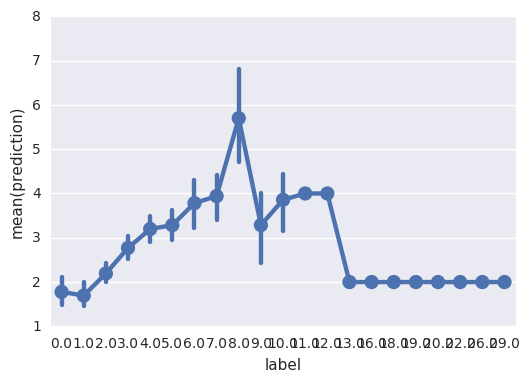

In [74]:
# Show the results of a linear regression within each dataset
p = sns.pointplot(
    x='label', 
    y='prediction', 
    data=df_plot,
    size=8
)
p